# Data Visualisation
This Jupyter Notebook contains code that visualises the data used in the thesis. First the networks are drawn then the raw and processed data, and finally the results are visualised

In [145]:
# Required packages (check which are required)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
import datetime as dt
import community
from shapely.geometry import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

import random
import math

import cmocean as cmo


%matplotlib inline

In [146]:
# Read the data from data_processing.ipynb
# Calibration Data
sa_calibration_data = pd.read_csv('../Data_Labour/calibration_data.csv', sep = ',', index_col = 0)

# Network Data
absolute_workers = pd.read_csv('../Data_Labour/Occupation_transitions.csv', sep = ',', index_col = 0)
frey_osborne_translated = pd.read_csv('../Data_Labour/occupation_shock.csv', sep = ',', index_col = 'ssyk3')
employment_SSYK = pd.read_csv('../Data_Labour/occupational_employment.csv', sep = ',')
node_data = pd.read_csv('../Data_Labour/occupational_data.csv', sep = ',', index_col = 'ssyk3')

# Occupational Mobility Network
G = nx.read_graphml('../Data_Labour/Occ_mob_sweden.graphml')

# Occupational Mobility Network

In [224]:
# This sets up the visualization of the network
# The size of the nodes is proportional to the amount of workers who 
# stayed in their proffesion between 2016 and 2017
def softmax(A,k=1.0):
    """
    Calculates the softmax of a distribution, modulated by the precision term, k
    Used here to adjust the size of the nodes
    """
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    A = A*k
    maxA = A.max()
    A = A-maxA
    A = np.exp(A)
    return A/np.sum(A)

# Create the graph G from the adjeceny matrix
G = nx.read_graphml('../Data_Labour/Occ_mob_sweden.graphml')

# List of all the occupation codes
occupations = list(G.nodes)

# Dictionaries holding the first and second levels of the SSYK code respectively
first_level = {name:name[0] for name in occupations}
second_level = {name:name[0:1] for name in occupations}

# The amount of workers who stayed in their proffession
remain_workers = np.diag(absolute_workers)

# Make it into a dict 
remain_dict = dict(zip(list(G.nodes), remain_workers))

# Calculate the size of each node
ns = softmax(0.7*np.log2(50000+np.array(list(remain_dict.values()))))*10000

# Give the network the attributes used for visualisation
nx.set_node_attributes(G, first_level, 'SSYK1')
nx.set_node_attributes(G, second_level, 'SSYK2')
nx.set_node_attributes(G, remain_dict, 'remained_workers')

# Ten colors used for visualisation
cols = ["#69b243", "#ad5ec7", "#bfaf48", "#7778c8", "#c87f41", 
        "#4bafd0", "#ce4a3d", "#55a977", "#cd4b8f", "#70742e", "#c36a7c"]

# Get all the unique first level codes
vals = list(set(val for val in first_level.values()))

# Make a dict that stores the color each node should get based on their first level
col_dict = {}
for i in range(len(vals)):
    col_dict[vals[i]] = cols[i]

# Make a list that contains the color of every node
node_col_list = [col_dict[val] for val in first_level.values()]
edge_col_list = [col_dict[val[0]] for val,_ in G.edges()]

# Make a list that contains the weight for each link
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
weights = softmax(0.7*np.log2(1000+np.array(weights)))*1500

circle_pos = nx.circular_layout(G, scale=1, center=None, dim=2)
spring_pos = nx.spring_layout(G, iterations = 50, k = 0.2)


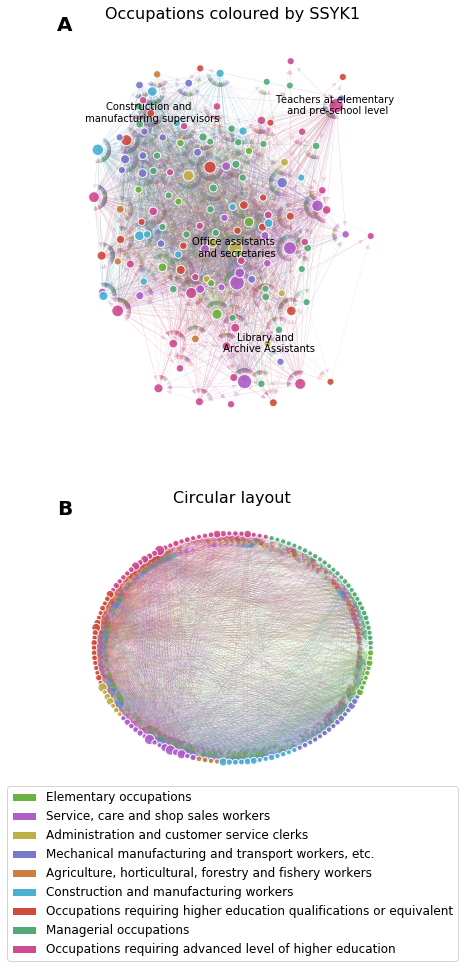

In [289]:
# This section visualises the network where nodes are colored by their first level code 
# and the size correspond to the number of workers who stayed in their proffession

fig, axs = plt.subplots(2,1,figsize=(6,14), gridspec_kw={'height_ratios': [3, 2]})

legend_elements = []

occ_dict = {'1': 'Chefsyrken', 
            '2': 'Yrken med krav på fördjupad högskolekompetens', 
            '3': 'Yrken med krav på högskolekompetens eller motsvarande', 
            '4': 'Yrken inom administration och kundtjänst', 
            '5': 'Service-, omsorgs- och försäljningsyrken', 
            '6': 'Yrken inom lantbruk, trädgård, skogsbruk och fiske', 
            '7': 'Yrken inom byggverksamhet och tillverkning', 
            '8': 'Yrken inom maskinell tillverkning och transport m.m.', 
            '9': 'Yrken med krav på kortare utbildning eller introduktion'}

en_occ_dict = {'1': 'Managerial occupations', 
               '2': 'Occupations requiring advanced level of higher education', 
               '3': 'Occupations requiring higher education qualifications or equivalent', 
               '4': 'Administration and customer service clerks', 
               '5': 'Service, care and shop sales workers', 
               '6': 'Agriculture, horticultural, forestry and fishery workers', 
               '7': 'Construction and manufacturing workers', 
               '8': 'Mechanical manufacturing and transport workers, etc.', 
               '9': 'Elementary occupations'}


for level, col in col_dict.items():
    legend_elements.append(Patch(facecolor = col, edgecolor='w', label=en_occ_dict[level]))

nx.draw_networkx_nodes(G, spring_pos, with_labels = True, node_color=node_col_list, node_size = ns, 
                       alpha=0.9, edgecolors='w', ax = axs[0])

nx.draw_networkx_edges(G, spring_pos, edge_color=edge_col_list, width=weights, alpha=0.2, ax=axs[0])

# Only certain nodes should be labelled
# labels = {str(key): str(key) for key in G.nodes()}

# nx.draw_networkx_labels(G, pos, labels, font_size=16)

axs[0].set_axis_off()
axs[1].set_axis_off()

axs[0].set_title("Occupations coloured by SSYK1", fontsize=16)


nx.draw_networkx_nodes(G, circle_pos, node_color=node_col_list, node_size = ns*0.5, alpha=0.9, 
                       edgecolors='w', ax = axs[1])

nx.draw_networkx_edges(G, circle_pos, edge_color=edge_col_list, width=weights, alpha=0.2, ax=axs[1])
labels = {'441': 'Library and \n Archive Assistants', 
          '411': 'Office assistants \n and secretaries', 
          '234': 'Teachers at elementary \n and pre-school level',
          '312': 'Construction and \n manufacturing supervisors'}

nx.draw_networkx_labels(G,spring_pos,labels,font_size=10, ax = axs[0])

axs[1].set_title('Circular layout', fontsize = 16)

axs[0].text(0, 1, 'A', fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=axs[0].transAxes, fontweight='bold')
axs[1].text(0, 1, 'B', fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=axs[1].transAxes, fontweight='bold')


axs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, 0), loc='upper center', borderaxespad=0., fontsize =12)


plt.savefig('../Graphs/Occ_mob_SSYK.pdf', dpi=425, bbox_inches='tight')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable funct

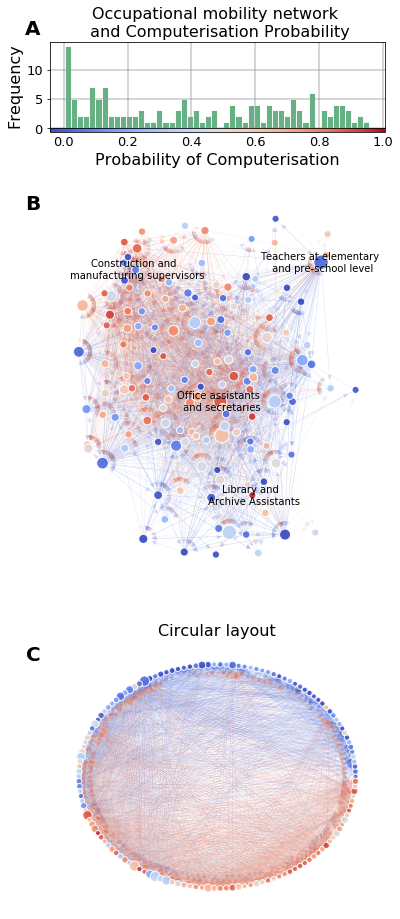

In [292]:
# Visualisation of Frey and Osborne data
# This section visualises the network where nodes are colored by their first level code and the size correspond 
# to the number of workers who stayed in their proffession
fig, axs = plt.subplots(3,1,figsize=(6,16), gridspec_kw={'height_ratios': [1, 4.5, 3]})


fo_dict = {str(key):val for key, val in frey_osborne_translated.to_dict()['Computerisation Probability'].items()}

fo_vals = list(fo_dict.values())

axs[0].hist(fo_vals, bins = 50, ec = 'white', alpha = 0.9, color = "#55a977")
axs[0].set_ylabel('Frequency', fontsize=16)
axs[0].set_xlabel('Probability of Computerisation', fontsize=16)
axs[0].grid(linewidth=2, color='#999999', alpha=0.4)
axs[0].tick_params(axis='both', which='both', labelsize=13,
                labelbottom=True, bottom=True, labelleft=True, left=True)


node_colors = [plt.cm.coolwarm(fo_dict[occ]) for occ in G.nodes]
edge_colors = [plt.cm.coolwarm(fo_dict[occ], alpha = 0.2) for occ,_ in G.edges]



sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(0,1))
sm._A = []

divider = make_axes_locatable(axs[0])
cax = divider.new_vertical(size="5%", pad=0, pack_start=True)
fig.add_axes(cax)

plt.colorbar(sm, cax = cax, orientation = 'horizontal', anchor = (0.5,1), panchor = (0.5, -0.1))


nx.draw_networkx_nodes(G, spring_pos, with_labels = True, node_color=node_colors, node_size = ns, alpha=0.95, 
                       edgecolors='w', ax = axs[1])
nx.draw_networkx_edges(G, spring_pos, edge_color= edge_colors, width=weights, alpha=0.2, ax=axs[1])

nx.draw_networkx_nodes(G, circle_pos, node_color=node_colors, node_size = ns*0.5, alpha=0.9, 
                       edgecolors='w', ax = axs[2])
nx.draw_networkx_edges(G, circle_pos, edge_color=edge_colors, width=weights, alpha=0.2, ax=axs[2])

nx.draw_networkx_labels(G,spring_pos,labels,font_size=10, ax = axs[1])

axs[2].set_title('Circular layout', fontsize = 16)

axs[0].text(-0.05, 1.15, 'A', fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=axs[0].transAxes, fontweight='bold')
axs[1].text(-0.05, 0.95, 'B', fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=axs[1].transAxes, fontweight='bold')
axs[2].text(-0.05, 0.95, 'C', fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=axs[2].transAxes, fontweight='bold')

axs[1].set_axis_off()
axs[2].set_axis_off()

axs[0].set_title("Occupational mobility network \n and Computerisation Probability", fontsize=16)

plt.savefig('../Graphs/Occ_mob_CP.pdf', dpi=425, bbox_inches='tight')
plt.show()

# Beveridge Curve

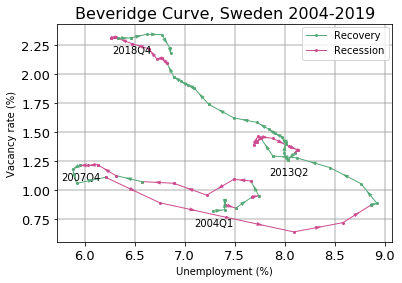

In [306]:
sa_calibration_data = pd.read_csv('../Data_Labour/calibration_data.csv')

plot_ls = []
plot_dict = {'u': [], 'vac': [], 'date': []}
status = False

for i in range(len(sa_calibration_data)):
    current_status = sa_calibration_data['gap_change'].iloc[i] >= 0
    if current_status == status:
        plot_dict['date'].append(sa_calibration_data['date'].iloc[i])
        plot_dict['u'].append(sa_calibration_data['u_trend'].iloc[i])
        plot_dict['vac'].append(sa_calibration_data['sa_vac_rate'].iloc[i])
        plot_dict['gap_change'] = status
    else:
        plot_ls.append(plot_dict)
        plot_dict = {'u': [sa_calibration_data['u_trend'].iloc[i-1]], 
                    'vac': [sa_calibration_data['sa_vac_rate'].iloc[i-1]], 
                     'date': [sa_calibration_data['date'].iloc[i-1]]}
        plot_dict['u'].append(sa_calibration_data['u_trend'].iloc[i])
        plot_dict['vac'].append(sa_calibration_data['sa_vac_rate'].iloc[i])
        plot_dict['gap_change'] = status
        status = current_status

plot_ls.append(plot_dict)


fig, ax = plt.subplots()
cols = [ "#55a977", "#cd4b8f"]
legend_elements = []
first_rec = True
first_rece = True

for i, data in enumerate(plot_ls):
    if data['gap_change'] == False:
        if first_rec == True:
            plt.plot(data['u'], data['vac'], color = cols[0], ls = '-', marker = 'o', 
                     linewidth = 1, markersize = 2, 
                     label = 'Recovery')
            first_rec = False
        else:
            plt.plot(data['u'], data['vac'], color = cols[0], ls = '-', marker = 'o', 
                     linewidth = 1, markersize = 2)
        x = data['u']
        y = data['vac']
        u = np.diff(x)
        v = np.diff(y)
        pos_x = x[:-1] + u/2
        pos_y = y[:-1] + v/2
        norm = np.sqrt(u**2+v**2) 
        ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", scale = 50, color = cols[0])
        if i % 4 == 0 or i == len(plot_ls)-1:
            plt.annotate(data['date'][0], # this is the text
            (data['u'][0], data['vac'][0]), # this is the point to label
            textcoords="offset points", # how to position the text
            xytext=(1,-15), # distance from text to points (x,y)
            ha='center')
    else:
        if first_rece == True:
            plt.plot(data['u'], data['vac'], color = cols[1], ls = '-', marker = 'o', 
                     linewidth = 1, markersize = 2, 
                     label = 'Recession')
            first_rece = False
        else:
            plt.plot(data['u'], data['vac'], color = cols[1], ls = '-', marker = 'o', 
                     linewidth = 1, markersize = 2)
        x = data['u']
        y = data['vac']
        u = np.diff(x)
        v = np.diff(y)
        pos_x = x[:-1] + u/2
        pos_y = y[:-1] + v/2
        norm = np.sqrt(u**2+v**2) 
        ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", scale = 50, color = cols[1])

ax.grid(linewidth=2, color='#999999', alpha=0.4)
ax.tick_params(axis='both', which='both', labelsize=13,
                labelbottom=True, bottom=True, labelleft=True, left=True)
plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0.)
ax.set_title("Beveridge Curve, Sweden 2004-2019", fontsize=16)
ax.set_xlabel('Unemployment (%)')
ax.set_ylabel('Vacancy rate (%)')
plt.savefig('../Graphs/Beveridge_curve.pdf', dpi=425, bbox_inches='tight')
plt.show()

# Results

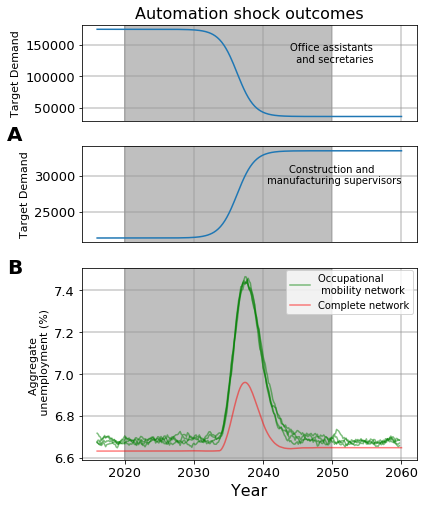

In [284]:
# Import ABM data
abm_data = pd.read_csv('../Data_Labour/simulation_output/processed_outcome_over_time.csv', sep = ',')
labels = {'441': 'Library and \n Archive Assistants', 
          '411': 'Office assistants \n and secretaries', 
          '234': 'Teachers at elementary \n and pre-school level',
          '312': 'Construction and \n manufacturing supervisors'}

# Deterministic simulation data
td_data = pd.read_csv('../Data_Labour/simulation_output/c_det_td_simulation_30.csv', sep = ',')
c_e_data = pd.read_csv('../Data_Labour/simulation_output/c_det_emp_simulation_30.csv', sep = ',')
c_u_data = pd.read_csv('../Data_Labour/simulation_output/c_det_unemp_simulation_30.csv', sep = ',')

period = 10.25*1.5
shock_period = 30
timestep = 8


cols = ["#89b3da", "#dd98a0"]
td_data = td_data.iloc[int(period*52/timestep):-int((period-4)*52/timestep)].reset_index(drop = True)
c_u_agg = c_u_data.iloc[int(period*52/timestep):-int((period-4)*52/timestep)].sum(1)
c_e_agg = c_e_data.iloc[int(period*52/timestep):-int((period-4)*52/timestep)].sum(1)

c_u_rel = pd.Series([c_u/(c_e_agg.iloc[i]+ c_u) for i,c_u in enumerate(c_u_agg)])




td_list = [pd.Series(td_data['411']), pd.Series(td_data['312'])]

fig, axs = plt.subplots(3, 1, figsize = (6, 8), gridspec_kw={'height_ratios': [1, 1, 2]})

label_list = [labels['411'], labels['312'], 'Occupational \n mobility network']

for i, ax in enumerate(axs):    
    ax.axvspan(period/4 + 2016, period/4 + shock_period + 2016, alpha=0.5, color='grey')
    ax.grid(linewidth=2, color='#999999', alpha=0.4)
    ax.tick_params(axis='both', which='both', labelsize=13,
                   labelbottom=True, bottom=True, labelleft=True, left=True)
    if i == 0:
        ax.plot(td_list[i].index*timestep/52 + 2016, td_list[i].values, label = labels['441'])
        ax.set_title('Automation shock outcomes', fontsize = 16)
        ax.set_ylabel('Target Demand', fontsize = 11)
        ax.tick_params(axis='both', which='both', labelsize=13,
                labelbottom=False, bottom=False, labelleft=True, left=True)
        ax.text(0.75, .7, labels['411'], fontsize=10, horizontalalignment='center',
           verticalalignment='center', transform=ax.transAxes)
        ax.text(-0.2, -0.15, 'A', fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=ax.transAxes, fontweight='bold')
    elif i == 1:
        ax.plot(td_list[i].index*timestep/52 + 2016, td_list[i].values, label = labels['312'])
        ax.set_ylabel('Target Demand', fontsize = 11)
        ax.tick_params(axis='both', which='both', labelsize=13,
                labelbottom=False, bottom=False, labelleft=True, left=True)
        ax.text(0.75, .7, labels['312'], fontsize=10, horizontalalignment='center',
           verticalalignment='center', transform=ax.transAxes)
    elif i == 2:
        ax.set_ylabel('Aggregate \n unemployment (%)', fontsize = 11)
        ax.text(-0.2, 1, 'B', fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=ax.transAxes, fontweight='bold')
        ax.set_xlabel('Year', fontsize = 16)
        for j, sim in enumerate(abm_data):
            data = abm_data[sim]
            if j == 0:
                ax.plot(data.index*timestep/52 + 2016, data.values, color = 'g', alpha = 0.5, 
                    label = 'Occupational \n mobility network')
            else:
                ax.plot(data.index*timestep/52 + 2016, data.values, color = 'g', alpha = 0.5)

        ax.plot(c_u_rel.index*timestep/52 + 2016, c_u_rel.values*100, label = 'Complete network', 
                color = 'r', alpha = 0.5)
                
plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0.)

plt.savefig('../Graphs/automation_outcome.pdf', dpi=425, bbox_inches='tight')
plt.show()

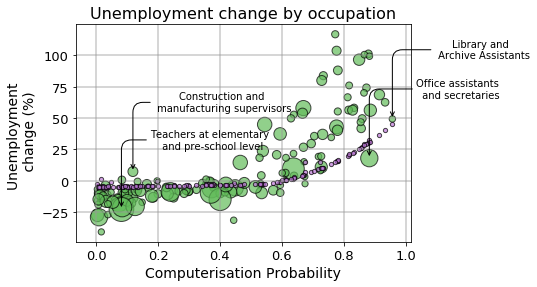

In [305]:

avg_data = pd.read_csv('../Data_Labour/simulation_output/occ_unemp.csv', sep =',', index_col = 0)

cols = ["#62bc5a", "#bd77d7"]

fig, ax = plt.subplots(1, 1, figsize = (6,4))

ax.grid(linewidth=2, color='#999999', alpha=0.4)
ax.tick_params(axis='both', which='both', labelsize=13,
                labelbottom=True, bottom=True, labelleft=True, left=True)
ax.grid(linewidth=2, color='#999999', alpha=0.4)
ax.tick_params(axis='both', which='both', labelsize=13,
                labelbottom=True, bottom=True, labelleft=True, left=True)

labels = {'441': 'Library and \n Archive Assistants', 
          '411': 'Office assistants \n and secretaries', 
          '234': 'Teachers at elementary \n and pre-school level',
          '312': 'Construction and \n manufacturing supervisors'}


for occ, lab in labels.items():
    ax.annotate(lab, (avg_data['Computerisation Probability'].loc[int(occ)], avg_data['u_change'].loc[int(occ)]),
                textcoords='offset points',
                xytext=(90, 80),
                arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=90,rad=10"),
                horizontalalignment='center', verticalalignment='top')
    
ax.set_title('Unemployment change by occupation', fontsize = 16)

ax.scatter(avg_data['Computerisation Probability'], avg_data['u_change'], s = avg_data['size'], 
               c = cols[0], alpha = 0.7, ec = 'k')
ax.scatter(avg_data['Computerisation Probability'], avg_data['c_u_change'], c = cols[1], s = min(sizes)-20, alpha = 0.7, 
           ec = 'k')
ax.set_ylabel('Unemployment \n change (%)', fontsize = 14)
ax.set_xlabel('Computerisation Probability', fontsize = 14)

plt.savefig('../Graphs/unemployment_occupation.pdf', dpi=425, bbox_inches='tight')

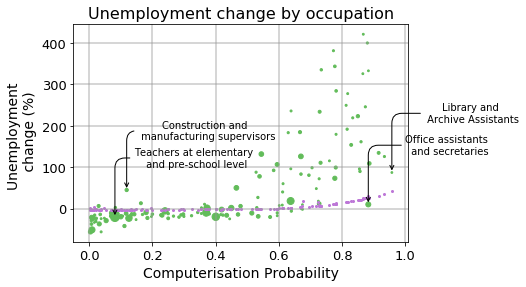

In [272]:
# Simulation data
e_data = pd.read_csv('../Data_Labour/simulation_output/long_robust_emp_simulation_30.csv', sep = ',')
u_data = pd.read_csv('../Data_Labour/simulation_output/long_robust_unemp_simulation_30.csv', sep = ',')
c_e_data = pd.read_csv('../Data_Labour/simulation_output/c_emp_simulation_30.csv', sep = ',')
c_u_data = pd.read_csv('../Data_Labour/simulation_output/c_unemp_simulation_30.csv', sep = ',')

# ABM data
abm_datalist = []
abm_datalist.append(pd.read_csv('../Data_Labour/simulation_output/abm_emp_simulation_1.csv', sep = ','))
abm_datalist.append(pd.read_csv('../Data_Labour/simulation_output/abm_unemp_simulation_1.csv', sep = ','))
abm_datalist.append(pd.read_csv('../Data_Labour/simulation_output/abm_emp_simulation_2.csv', sep = ','))
abm_datalist.append(pd.read_csv('../Data_Labour/simulation_output/abm_unemp_simulation_2.csv', sep = ','))
abm_datalist.append(pd.read_csv('../Data_Labour/simulation_output/c_abm_emp_simulation_1.csv', sep = ','))
abm_datalist.append(pd.read_csv('../Data_Labour/simulation_output/c_abm_unemp_simulation_1.csv', sep = ','))
abm_datalist.append(pd.read_csv('../Data_Labour/simulation_output/c_abm_emp_simulation_2.csv', sep = ','))
abm_datalist.append(pd.read_csv('../Data_Labour/simulation_output/c_abm_unemp_simulation_2.csv', sep = ','))

start = int(period*(4/3)*52/timestep)
e_start = e_data.iloc[start]
u_start = u_data.iloc[start]

c_e_start = c_e_data.iloc[start]
c_u_start = c_u_data.iloc[start]

e_avg = e_data.iloc[start:].mean(0)
u_avg = u_data.iloc[start:].mean(0)

c_e_avg = c_e_data.iloc[start:].mean(0)
c_u_avg = c_u_data.iloc[start:].mean(0)

u_avg_rel = pd.DataFrame([u/(u+e_avg.iloc[i]) for i, u in enumerate(u_avg)], 
                         index = u_avg.index, columns = ['u'])
c_u_avg_rel = pd.DataFrame([u/(u+c_e_avg.iloc[i]) for i, u in enumerate(c_u_avg)], 
                         index = c_u_avg.index, columns = ['c_u'])

e_avg.name = 'e'
c_e_avg.name = 'c_e'

u_avg_rel.index = u_avg_rel.index.astype(int)
e_avg.index = e_avg.index.astype(int)

c_u_avg_rel.index = c_u_avg_rel.index.astype(int)
c_e_avg.index = c_e_avg.index.astype(int)

# Computerisation probability
frey_osborne_translated.index.name = None

avg_data = frey_osborne_translated.merge(u_avg_rel, left_index = True, right_index = True)
avg_data = avg_data.merge(e_avg, left_index = True, right_index = True)
avg_data = avg_data.merge(c_u_avg_rel, left_index = True, right_index = True)
avg_data = avg_data.merge(c_e_avg, left_index = True, right_index = True)

# Starting values

avg_data['u_start'] =  [u/(u+e_start.iloc[i]) for i, u in enumerate(u_start)]
avg_data['u_change'] = (avg_data['u'] - avg_data['u_start'])*100/avg_data['u_start']

avg_data['c_u_start'] =  [u/(u+c_e_start.iloc[i]) for i, u in enumerate(c_u_start)]
avg_data['c_u_change'] = (avg_data['c_u'] - avg_data['c_u_start'])*100/avg_data['c_u_start']



sizes = softmax(0.7*np.log2(10000+np.array(list(avg_data['e']))))*1500
avg_data['size'] = sizes

data_list = []
data_list.append(avg_data)
data_list.append(avg_data)


# Pick example occupations

cols = ["#62bc5a", "#bd77d7"]

# Unemployment against computerisation probability
# size of each point proportional to employment at given time
# Both complete network and occupational mobility network


fig, ax = plt.subplots(1, 1, figsize = (6,4))

ax.grid(linewidth=2, color='#999999', alpha=0.4)
ax.tick_params(axis='both', which='both', labelsize=13,
                labelbottom=True, bottom=True, labelleft=True, left=True)
ax.grid(linewidth=2, color='#999999', alpha=0.4)
ax.tick_params(axis='both', which='both', labelsize=13,
                labelbottom=True, bottom=True, labelleft=True, left=True)

labels = {'441': 'Library and \n Archive Assistants', 
          '411': 'Office assistants \n and secretaries', 
          '234': 'Teachers at elementary \n and pre-school level',
          '312': 'Construction and \n manufacturing supervisors'}


for occ, lab in labels.items():
    ax.annotate(lab, (avg_data['Computerisation Probability'].loc[int(occ)], avg_data['u_change'].loc[int(occ)]),
                textcoords='offset points',
                xytext=(80, 70),
                arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=90,rad=10"),
                horizontalalignment='center', verticalalignment='top')
    
ax.set_title('Unemployment change by occupation', fontsize = 16)

ax.scatter(avg_data['Computerisation Probability'], avg_data['u_change'], s = avg_data['size'], 
               c = cols[0])
ax.scatter(avg_data['Computerisation Probability'], avg_data['c_u_change'], c = cols[1], s = 4)
ax.set_ylabel('Unemployment \n change (%)', fontsize = 14)
ax.set_xlabel('Computerisation Probability', fontsize = 14)

plt.savefig('../Graphs/unemployment_occupation.pdf', dpi=425, bbox_inches='tight')

In [270]:
avg_data

,Computerisation Probability,u,e,c_u,c_e,u_start,u_change,c_u_start,c_u_change,size
111,0.100500,0.048287,5134.929949,0.064656,5079.039877,0.049850,-3.136874,0.065810,-1.752791,5.005076
112,0.087500,0.054668,32853.260925,0.064724,32497.610429,0.055754,-1.948050,0.066436,-2.576681,11.997452
121,0.069000,0.055727,22894.202442,0.064664,22627.588957,0.060941,-8.556429,0.066232,-2.366708,9.478691
122,0.323933,0.052725,8319.475578,0.064787,8336.018405,0.054687,-3.588761,0.066150,-2.060991,5.805101
123,0.423125,0.053917,10161.320694,0.065041,10255.300613,0.056935,-5.301730,0.066100,-1.602289,6.268315
...,...,...,...,...,...,...,...,...,...,...
932,0.705000,0.061819,6769.016067,0.069910,7102.521472,0.053118,16.381722,0.066255,5.515330,5.415448
933,0.528000,0.057861,6493.820694,0.065292,6629.917178,0.051845,11.603967,0.066248,-1.443476,5.346315
941,0.886250,0.085168,30093.909383,0.083524,33459.322086,0.060902,39.843742,0.066353,25.878273,11.299009
961,0.629667,0.065655,6163.270566,0.066979,6381.665644,0.048677,34.879640,0.066013,1.463012,5.263289
